In [1]:
#%%html
#<link rel="stylesheet" href="style/style.css">

# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument 'uncertainty_sampling' of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument scenarios changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to perform_experiments. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the get_SALib_problem function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ema_workbench import (Model, RealParameter, Constant, ScalarOutcome, TimeSeriesOutcome, perform_experiments, ema_logging, SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd
import seaborn as sns

In [3]:
# Set up model

import lakemodel_function as lake

model = Model('Lakemodel', function=lake.lake_problem)

uncertainties = [RealParameter('mean', 0.01, 0.5),
                 RealParameter('stdev', 0.001, 0.005),
                 RealParameter('b', 0.1, 0.45),
                 RealParameter('q', 2, 4.5),
                 RealParameter('delta', 0.93, 0.99)]

outcomes = [ScalarOutcome('max_P', ScalarOutcome.MINIMIZE),
            ScalarOutcome('utility', ScalarOutcome.MAXIMIZE),
            ScalarOutcome('inertia', ScalarOutcome.INFO),
            ScalarOutcome('reliability', ScalarOutcome.MAXIMIZE)]
# assumption that inertia does not matter and is only there to provide info.

model.uncertainties = uncertainties

# model.levers = [RealParameter("l" + str(number),0,0.1) for number in range(0,100)]

model.outcomes = outcomes

# 3 seperate release policies (0, 0.05, and 0.1)
# TODO: pass as a list for ease after initial testing succeeds
model.constants = [Constant('l' + str(i), 0) for i in range(100)]

In [4]:
# Model run
processes = 8
N = 50
D = len(uncertainties)
#ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(model) as evaluator:
    # I think no policies because levers is a constant?
    experiments, outcomes = evaluator.perform_experiments(scenarios = N * (2 * D + 2), uncertainty_sampling=SOBOL)

C:\Users\David2\anaconda3\envs\gds\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)


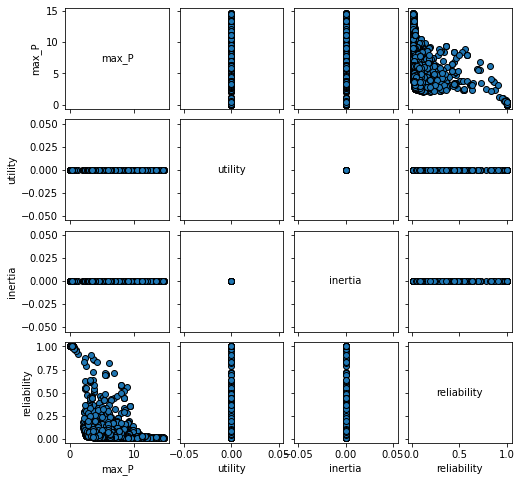

In [5]:
from ema_workbench.analysis import pairs_plotting
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, legend=False)
fig.set_size_inches(8,8)
plt.show()

<div class="analysis">
I am David the inventor of S3x u can call me fishdoorbellguy.    
</div>

<div style="color: GREEN">
David: wut

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*
